<div>
    <div style="float:left;">
        <img src="http://oproject.org/tiki-download_file.php?fileId=8&display&x=450&y=128" width="50%" />
    </div>
    <div style="float:left;">
        <img src="http://gfif.udea.edu.co/root/tmva/img/tmva_logo.gif" width="50%"/>
    </div>
</div>

# JIMVA
<hr style="border-top-width: 4px; border-top-color: #34609b;">

In [1]:
import ROOT
from ROOT import TFile, TMVA, TCut

Welcome to JupyROOT 6.07/07


## Declare Factory and DataLoader

In [2]:
outputFile = TFile("files/TMVAOutput.root", "RECREATE")
inputFile  = TFile("files/mydataset.root")

TMVA.Tools.Instance()

factory = TMVA.Factory("TMVAClassification",
                       outputFile,
                       "!V:ROC:!Correlations:!Silent:Color:!DrawProgressBar:AnalysisType=Classification")
loader = TMVA.DataLoader("mydataset")

--- Factory                  : You are running ROOT Version: 6.07/07, Apr 1, 2016
--- Factory                  : 
--- Factory                  : _/_/_/_/_/ _|      _|  _|      _|    _|_|   
--- Factory                  :    _/      _|_|  _|_|  _|      _|  _|    _| 
--- Factory                  :   _/       _|  _|  _|  _|      _|  _|_|_|_| 
--- Factory                  :  _/        _|      _|    _|  _|    _|    _| 
--- Factory                  : _/         _|      _|      _|      _|    _| 
--- Factory                  : 
--- Factory                  : ___________TMVA Version 4.2.1, Feb 5, 2015
--- Factory                  : 


## Adding variables to DataLoader

In [3]:
# Adding variables to dataset
loader.AddVariable("var0", 'F')
loader.AddVariable("var1", 'F')
loader.AddVariable("var2", 'F')
loader.AddVariable("var3 := var0-var1", 'F')
loader.AddVariable("var4 := var0*var2", 'F')
loader.AddVariable("var5 := var1+var2", 'F')

## Setting up dataset from Trees

In [4]:
print "--- TMVAClassification       : Using input file:", inputFile.GetName()
   
# Register the training and test trees

tsignal     = inputFile.Get("MyMCSig")
tbackground = inputFile.Get("MyMCBkg")
     
signalWeight     = 1.0
backgroundWeight = 1.0

mycuts = TCut("")
mycutb = TCut("")

loader.AddSignalTree(tsignal, signalWeight)
loader.AddBackgroundTree(tbackground, backgroundWeight)
loader.fSignalWeight = signalWeight
loader.fBackgroundWeight = backgroundWeight
loader.fTreeS = tsignal
loader.fTreeB = tbackground
loader.PrepareTrainingAndTestTree(mycuts,
                                  mycutb,
                                  "nTrain_Signal=3000:nTrain_Background=3000:nTest_Signal=1449:nTest_Background=1449:SplitMode=Random:NormMode=NumEvents:!V")

--- TMVAClassification       : Using input file: files/mydataset.root
--- DataSetInfo              : Dataset[mydataset] : Added class "Signal"	 with internal class number 0
--- mydataset                : Add Tree MyMCSig of type Signal with 5449 events
--- DataSetInfo              : Dataset[mydataset] : Added class "Background"	 with internal class number 1
--- mydataset                : Add Tree MyMCBkg of type Background with 5449 events
--- mydataset                : Preparing trees for training and testing...


In [5]:
%jsmva on

In [7]:
loader.DrawInputVariable("var0")

Warning in <TFile::Append>: Replacing existing TH1: Signal (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Background (Potential memory leak).


In [8]:
loader.DrawInputVariable("var0", processTrfs="D") #I;N;D;P;U;G,D

--- mydataset                : Dataset[mydataset] : Create Transformation "D" with events from all classes.
--- Deco                     : Transformation, Variable selection : 
--- Deco                     : Input : variable 'var0' (index=0).   <---> Output : variable 'var0' (index=0).
--- Deco                     : Input : variable 'var1' (index=1).   <---> Output : variable 'var1' (index=1).
--- Deco                     : Input : variable 'var2' (index=2).   <---> Output : variable 'var2' (index=2).
--- Deco                     : Input : variable 'var3' (index=3).   <---> Output : variable 'var3' (index=3).
--- Deco                     : Input : variable 'var4' (index=4).   <---> Output : variable 'var4' (index=4).
--- Deco                     : Input : variable 'var5' (index=5).   <---> Output : variable 'var5' (index=5).
--- Deco                     : Preparing the Decorrelation transformation...
--- <WARNING> Tools                    : <GetSQRootMatrix> error in matrix diagonaliza

Warning in <TFile::Append>: Replacing existing TH1: Signal (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Background (Potential memory leak).


In [9]:
%jsmva off

Warning in <TFile::Append>: Replacing existing TH1: Signal (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Background (Potential memory leak).


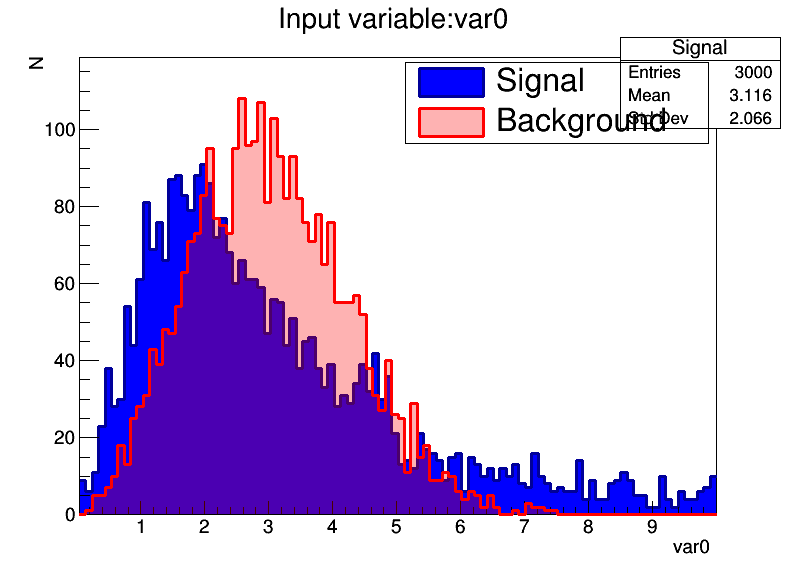

In [10]:
c,l=loader.InputVariable("var0")
c.Draw()

In [11]:
# Boosted Decision Trees
factory.BookMethod(loader,
                   TMVA.Types.kBDT,
                   "BDT",
                   "!V:NTrees=5:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20")

# TMVA ANN: MLP Multilayer Perceptrons
factory.BookMethod(loader,
                   TMVA.Types.kMLP,
                   "MLP",
                   "!V:NeuronType=tanh:VarTransform=N:NCycles=150:HiddenLayers=N+5:TestRate=5:!UseRegulator")

<ROOT.TMVA::MethodMLP object ("MLP") at 0x75a48d0>

--- Factory                  : Booking method: BDT DataSet Name: mydataset
--- Factory                  : Booking method: MLP DataSet Name: mydataset
--- MLP                      : Dataset[mydataset] : Create Transformation "N" with events from all classes.
--- Norm                     : Transformation, Variable selection : 
--- Norm                     : Input : variable 'var0' (index=0).   <---> Output : variable 'var0' (index=0).
--- Norm                     : Input : variable 'var1' (index=1).   <---> Output : variable 'var1' (index=1).
--- Norm                     : Input : variable 'var2' (index=2).   <---> Output : variable 'var2' (index=2).
--- Norm                     : Input : variable 'var3' (index=3).   <---> Output : variable 'var3' (index=3).
--- Norm                     : Input : variable 'var4' (index=4).   <---> Output : variable 'var4' (index=4).
--- Norm                     : Input : variable 'var5' (index=5).   <---> Output : variable 'var5' (index=5).
--- MLP      

In [12]:
%jsmva on
loader.DrawCorrelationMatrix("Signal")

## Training the Methods

In [13]:
factory.TrainAllMethods()

--- Factory                  :  
--- Factory                  : Train all methods for Classification ...
--- Factory                  : 
--- Factory                  : current transformation string: 'I'
--- Factory                  : Dataset[mydataset] : Create Transformation "I" with events from all classes.
--- Id                       : Transformation, Variable selection : 
--- Id                       : Input : variable 'var0' (index=0).   <---> Output : variable 'var0' (index=0).
--- Id                       : Input : variable 'var1' (index=1).   <---> Output : variable 'var1' (index=1).
--- Id                       : Input : variable 'var2' (index=2).   <---> Output : variable 'var2' (index=2).
--- Id                       : Input : variable 'var3' (index=3).   <---> Output : variable 'var3' (index=3).
--- Id                       : Input : variable 'var4' (index=4).   <---> Output : variable 'var4' (index=4).
--- Id                       : Input : variable 'var5' (index=5).   <-

In [14]:
factory.TestAllMethods()

factory.EvaluateAllMethods()

outputFile.Close()

print "==> TMVAClassification is done!"

--- Factory                  : Test all methods...
--- Factory                  : Test method: BDT for Classification performance
--- BDT                      : Dataset[mydataset] : Evaluation of BDT on testing sample (2898 events)
--- BDT                      : Dataset[mydataset] : Elapsed time for evaluation of 2898 events: 0.00188 sec       
--- Factory                  : Test method: MLP for Classification performance
--- MLP                      : Dataset[mydataset] : Evaluation of MLP on testing sample (2898 events)
--- MLP                      : Dataset[mydataset] : Elapsed time for evaluation of 2898 events: 0.00871 sec       
--- Factory                  : Evaluate all methods...
--- Factory                  : Evaluate classifier: BDT
--- BDT                      : Dataset[mydataset] : Loop over test events and fill histograms with classifier response...
--- Factory                  : Write evaluation histograms to file
--- TFHandler_BDT            : Plot event variables for B

In [15]:
factory.DrawROCCurve("mydataset")